# Project Introduction

This project revolves around predicting sales for thousands of product families available at Favorita stores in Ecuador. The provided dataset comprises various features such as dates, store and product information, promotional status, and sales figures. The goal is to accurately forecast sales based on these attributes.

## File Descriptions and Data Field Information

- **train.csv**: Contains the training data, consisting of time series information on store_nbr, family, onpromotion, and the target sales.
  - **store_nbr**: Identifies the store where products are sold.
  - **family**: Identifies the type of product sold.
  - **sales**: Represents the total sales for a product family at a specific store on a given date. Fractional values are possible.
  - **onpromotion**: Indicates the total number of items in a product family being promoted at a store on a given date.

- **test.csv**: Contains the test data with the same features as the training data. Predictions for target sales are required for the dates in this file.

- **sample_submission.csv**: A sample submission file provided in the correct format.

- **stores.csv**: Metadata about stores including city, state, type, and cluster.
  - **cluster**: Groups similar stores together.

- **oil.csv**: Daily oil price data, including values during both the train and test data timeframes. Given that Ecuador is oil-dependent, fluctuations in oil prices can significantly impact its economic health.

- **holidays_events.csv**: Holidays and Events data with metadata. Special attention needs to be paid to the transferred column which indicates holidays officially moved to another date by the government. Additional holidays are days added to regular calendar holidays.

This comprehensive dataset provides an opportunity to explore various factors influencing sales and to develop predictive models that can provide valuable insights for Favorita stores in Ecuador.


## Project Structure

*  **Imports:** Import necessary libraries and modules.

*  **Reading the Dataset:** Read each of the files containing the dataset.

*  **Saving the Dataset in MongoDB Atlas:** Store the dataset in MongoDB Atlas for further use.

* **Reading the Dataset from MongoDB:** Retrieve the dataset from MongoDB for preprocessing and analysis.

* **Preprocessing:** Perform data preprocessing tasks such as handling missing values, encoding categorical variables, etc.

* **Exploratory Data Analysis (EDA):** Utilize libraries like Sweetviz, Autoviz, and pandas profiling for comprehensive EDA to gain insights into the data.

* **Feature Engineering:** Create new features or modify existing features to improve model performance.

*  **Train Test Split:** Split the dataset into training and testing sets for model training and evaluation.

* **Scaling & One-Hot Encoding Features:** Scale numerical features and perform one-hot encoding on categorical features as required for model compatibility.

* **Modelling:** Build predictive models using machine learning algorithms.

* **Saved the Model:** Save the trained model for future use and reproducibility.

* **Submission:** Generate predictions using the trained model and prepare the submission file.


### Requirements.txt

In [1]:
!pip install -r requirements.txt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## imports

In [3]:
# Data Handling
import os
import pyodbc
from dotenv import dotenv_values
from dotenv import find_dotenv,load_dotenv
import numpy as np
import pandas as pd

#printing
from tabulate import tabulate

# Visualization
from ydata_profiling import ProfileReport
import sweetviz as sv

import pandas as pd
from autoviz import AutoViz_Class
%matplotlib inline

# Statistical Analysis

# Feature Processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
import xgboost as xgb

# Other Packages
import warnings
warnings.filterwarnings("ignore")

from pymongo import MongoClient
from bson import ObjectId
from typing import List, Dict
import pandas as pd
import json

random_state=42

# Load environment variables
config = find_dotenv(".env")
load_dotenv()

Imported v0.1.806. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


True

## Mongo DB

In [4]:
def delete_collection_data(my_database, my_collection, cluster_uri):
    """
    Delete all records from the specified collection in the specified database.

    Parameters:
    - my_database (str): Name of the MongoDB database.
    - my_collection (str): Name of the MongoDB collection.
    - cluster_uri (str): MongoDB connection URI.
    """
    # Connect to MongoDB
    client = MongoClient(cluster_uri)

    # Access the database and collection
    db = client[my_database]
    collection = db[my_collection]

    # Delete all records from the collection
    collection.delete_many({})

    # Close the MongoDB connection
    client.close()


def insert_dataframe_to_collection(my_database, my_collection, cluster_uri, dataframe_dict):
    """
    Insert the DataFrame records into the specified collection in the specified database.

    Parameters:
    - my_database (str): Name of the MongoDB database.
    - my_collection (str): Name of the MongoDB collection.
    - cluster_uri (str): MongoDB connection URI.
    """
    # Connect to MongoDB
    client = MongoClient(cluster_uri)

    # Access the database and collection
    db = client[my_database]
    collection = db[my_collection]

    # Iterate over each collection and DataFrame in the dictionary
    for collection_name, dataframe in dataframe_dict.items():
        # Access the collection
        collection = db[collection_name]

        # Delete all records from the collection
        collection.delete_many({})

        # Convert DataFrame to dictionary
        data = dataframe.to_dict(orient='records')

        # Insert data into MongoDB collection
        collection.insert_many(data)

    # Close the MongoDB connection
    client.close()



def query_collection_to_dataframe(my_database, my_collection, cluster_uri):
    """
    Query all records from the specified collection in the specified database,
    and load the data into a DataFrame.

    Parameters:
    - my_database (str): Name of the MongoDB database.
    - my_collection (str): Name of the MongoDB collection.
    - cluster_uri (str): MongoDB connection URI.

    Returns:
    - dataframe (DataFrame): DataFrame containing the queried records.
    """
    # Connect to MongoDB
    client = MongoClient(cluster_uri)

    # Access the database and collection
    db = client[my_database]
    collection = db[my_collection]

    # Query all records from the collection
    cursor = collection.find({})

    # Convert cursor to DataFrame
    dataframe = pd.DataFrame(list(cursor))

    # Close the MongoDB connection
    client.close()

    return dataframe

In [5]:
# MongoDB connection parameters
cluster_uri = os.getenv("CLUSTER_URI")
collection_name = os.getenv("MONGODB_COLLECTION")
database_name = os.getenv("MONGODB_DATABASE")

## Reading csv files

In [6]:
holidays_events = pd.read_csv('/content/drive/MyDrive/AIGot/Time Series Forecasting/holidays_events.csv')
oil = pd.read_csv('/content/drive/MyDrive/AIGot/Time Series Forecasting/oil.csv')
stores = pd.read_csv('/content/drive/MyDrive/AIGot/Time Series Forecasting/stores.csv')
transactions = pd.read_csv('/content/drive/MyDrive/AIGot/Time Series Forecasting/transactions.csv')
train=pd.read_csv('/content/drive/MyDrive/AIGot/Time Series Forecasting/train.csv')
test=pd.read_csv('/content/drive/MyDrive/AIGot/Time Series Forecasting/test.csv')


# print out the shapes of the dataset (train & test)
print("holidays_events",holidays_events.shape)
print("oil dataset",oil.shape)
print("stores dataset",stores.shape)
print("transactions dataset",transactions.shape)
print("Train dataset",train.shape)
print("Test dataset",test.shape)

holidays_events (350, 6)
oil dataset (1218, 2)
stores dataset (54, 5)
transactions dataset (83488, 3)
Train dataset (3000888, 6)
Test dataset (28512, 5)


## Preprocessing

In [7]:
def print_tabulated_data(data_frame):
    """
    Print tabulated data from a DataFrame.
    """
    print(tabulate(data_frame, headers='keys', tablefmt='psql'))


def explore_dataframe(df):
    """
    Perform basic exploratory data analysis on the input DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        None
    """
    # Print top 5 records
    print("-------------------------------TOP 5 RECORDS-----------------------------")
    print_tabulated_data(df.head(5))

    # Print DataFrame information
    print("-------------------------------INFO--------------------------------------")
    df_info = df.info()
    print_tabulated_data(df_info)

    # Print DataFrame description
    print("-------------------------------Describe----------------------------------")
    df_describe = df.describe()
    print_tabulated_data(df_describe)

    # Print column names
    print("-------------------------------Columns-----------------------------------")
    df_columns = df.columns
    print(df_columns)

    # Print data types
    print("-------------------------------Data Types--------------------------------")
    df_dtypes = df.dtypes
    print(df_dtypes)

    # Print missing values
    print("----------------------------Missing Values-------------------------------")
    df_missing_values = df.isnull().sum()
    print(df_missing_values)

    # Print NULL values
    print("----------------------------NULL values----------------------------------")
    df_null_values = df.isna().sum()
    print(df_null_values)

    # Print DataFrame shape
    print("--------------------------Shape Of Data---------------------------------")
    df_shape = df.shape
    print(df_shape)
    print("\n\n\n\n\n")

In [8]:
# Define a list of dataframes and their corresponding labels
datasets = [
    (train, "Train Data"),
    (test, "Test Data"),
    (holidays_events, "Holidays Events"),
    (transactions, "Transactions Data"),
    (stores, "Stores Data"),
    (oil, "Oil Data")
]

# Loop through each dataframe and label pair
for df, label in datasets:
    print("================================={}=================================".format(label))
    explore_dataframe(df)


=================================Train Data=================================
-------------------------------TOP 5 RECORDS-----------------------------
+----+------+------------+-------------+------------+---------+---------------+
|    |   id | date       |   store_nbr | family     |   sales |   onpromotion |
|----+------+------------+-------------+------------+---------+---------------|
|  0 |    0 | 2013-01-01 |           1 | AUTOMOTIVE |       0 |             0 |
|  1 |    1 | 2013-01-01 |           1 | BABY CARE  |       0 |             0 |
|  2 |    2 | 2013-01-01 |           1 | BEAUTY     |       0 |             0 |
|  3 |    3 | 2013-01-01 |           1 | BEVERAGES  |       0 |             0 |
|  4 |    4 | 2013-01-01 |           1 | BOOKS      |       0 |             0 |
+----+------+------------+-------------+------------+---------+---------------+
-------------------------------INFO--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30008

## Fill the Missing Values

In [9]:
#By using both forward fill and backward fill strategies, you ensure that missing values in the entire time series dataset, including the first and last rows, are appropriately filled based on adjacent non-missing values.


# Forward fill missing values from the first row to the last non-missing row
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='ffill')

# Backward fill missing values from the last row to the first non-missing row
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='bfill')


In [10]:
# Define a list of dataframes and their corresponding labels
datasets = [
    (oil, "Oil Data")
]

# Loop through each dataframe and label pair
for df, label in datasets:
    print("================================={}=================================".format(label))
    explore_dataframe(df)

=================================Oil Data=================================
-------------------------------TOP 5 RECORDS-----------------------------
+----+------------+--------------+
|    | date       |   dcoilwtico |
|----+------------+--------------|
|  0 | 2013-01-01 |        93.14 |
|  1 | 2013-01-02 |        93.14 |
|  2 | 2013-01-03 |        92.97 |
|  3 | 2013-01-04 |        93.12 |
|  4 | 2013-01-07 |        93.2  |
+----+------------+--------------+
-------------------------------INFO--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1218 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB

-------------------------------Describe----------------------------------
+-------+--------------+
|       |   dcoilwtico |
|-------+-----

In [11]:
import pandas as pd

def convert_to_datetime(df_list, date_column='date'):
    """
    Convert the 'date' column in the specified list of DataFrames to datetime format.
    """
    for df in df_list:
        df[date_column] = pd.to_datetime(df[date_column])

# Example usage:
convert_to_datetime([train])
convert_to_datetime([test])
convert_to_datetime([holidays_events])
convert_to_datetime([oil])
convert_to_datetime([transactions])

In [12]:
import pandas as pd

def check_dataset_completeness(data):
    min_date = data['date'].min()
    max_date = data['date'].max()
    expected_dates = pd.date_range(start=min_date, end=max_date)

    missing_dates = expected_dates[~expected_dates.isin(data['date'])]

    if len(missing_dates) == 0:
        print("It includes all the required dates.")
    else:
        print("The following dates are missing:")
        print(missing_dates)

    return missing_dates

def complete_missing_dates(data, missing_dates):
    missing_dates_index = pd.Index(missing_dates, dtype='datetime64[ns]')
    missing_data = pd.DataFrame({'date': missing_dates_index})
    data = pd.concat([data, missing_data], ignore_index=True)
    data.sort_values('date', inplace=True)
    return data

missing_dates = check_dataset_completeness(train)
train = complete_missing_dates(train, missing_dates)
missing_dates = check_dataset_completeness(train)


The following dates are missing:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)
It includes all the required dates.


In [13]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0
1194,1194.0,2013-01-01,42.0,CELEBRATION,0.0,0.0
1193,1193.0,2013-01-01,42.0,BREAD/BAKERY,0.0,0.0
1192,1192.0,2013-01-01,42.0,BOOKS,0.0,0.0
1191,1191.0,2013-01-01,42.0,BEVERAGES,0.0,0.0


## Merging dataset

In [14]:
def merge_datasets(train, stores, transactions, holidays_events, oil):
    merged_dataset1 = train.merge(stores, on='store_nbr', how="inner")
    merged_dataset2 = merged_dataset1.merge(transactions, on=['date', 'store_nbr'], how="inner")
    merged_dataset3 = merged_dataset2.merge(holidays_events, on='date', how="inner")
    merged_dataset = merged_dataset3.merge(oil, on='date', how="inner")

    # Rename the columns
    merged_dataset = merged_dataset.rename(columns={'type_x': 'type_of_store', 'type_y': 'type_of_holiday'})

    return merged_dataset

#'train', 'stores', 'transactions', 'holidays_events', and 'oil' are the input datasets
final_dataset = merge_datasets(train, stores, transactions, holidays_events, oil)


In [15]:
import pandas as pd

def extract_date_components(df, date_column):
    """
    Extracts year, month, and day components from a date column in a DataFrame.

    Args:
    df (pd.DataFrame): DataFrame containing the date column.
    date_column (str): Name of the date column in the DataFrame.

    Returns:
    pd.DataFrame: DataFrame with year, month, and day components added as new columns.
    """
    # Convert the date column to datetime
    df[date_column] = pd.to_datetime(df[date_column])

    # Extract year, month, and day components
    df['year'] = df[date_column].dt.year
    df['month'] = df[date_column].dt.month
    df['day'] = df[date_column].dt.day
    df['day_of_week'] = df[date_column].dt.dayofweek

    return df

# Example usage:
# Assuming 'merged_df_copy' is your DataFrame and 'date' is the name of the date column
final_dataset = extract_date_components(final_dataset, 'date')

# Automated EDA

    Since nrows is smaller than dataset, loading random sample of 150000 rows into pandas...
Shape of your Data Set loaded: (150000, 21)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  4
    Number of Integer-Categorical Columns =  5
    Number of String-Categorical Columns =  8
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  1
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  2
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    20 Predictors classified...
        No variables removed since no ID or low-information variables found in data se

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
id,float64,0.000000,NA,561.000000,3000884.000000,No issue
date,datetime64[ns],0.000000,0,,,Possible date-time colum: transform before modeling step.
store_nbr,float64,0.000000,NA,1.000000,54.000000,No issue
family,object,0.000000,0,,,No issue
onpromotion,float64,0.000000,NA,0.000000,672.000000,Column has 23371 outliers greater than upper bound (2.50) or lower than lower bound(-1.50). Cap them or remove them.
city,object,0.000000,0,,,1 rare categories: ['Puyo']. Group them into a single category or drop the categories.
state,object,0.000000,0,,,1 rare categories: ['Pastaza']. Group them into a single category or drop the categories.
type_of_store,object,0.000000,0,,,No issue
cluster,int64,0.000000,0,1.000000,17.000000,No issue
transactions,int64,0.000000,2,54.000000,8359.000000,Column has 7123 outliers greater than upper bound (3825.00) or lower than lower bound(-647.00). Cap them or remove them.


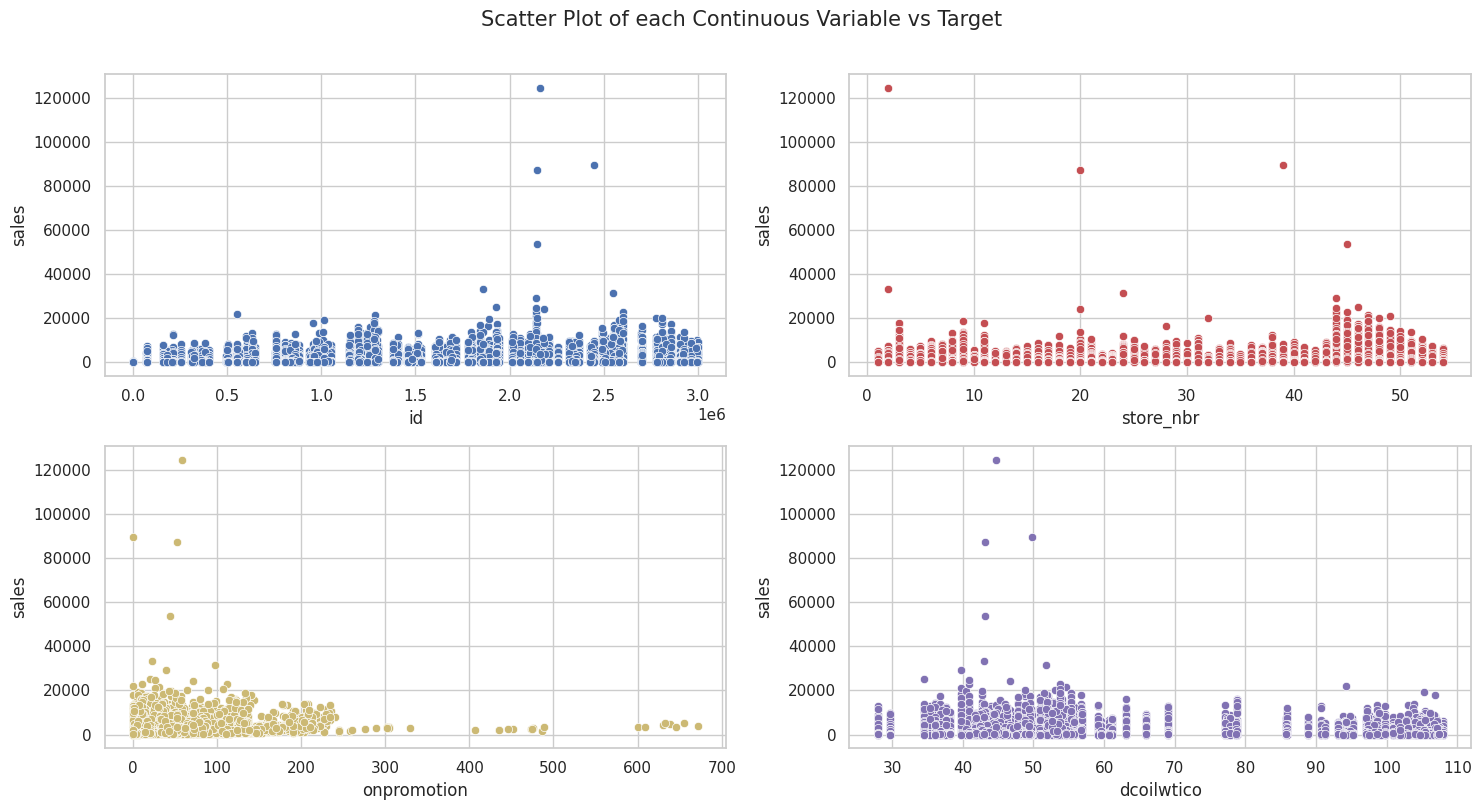

Number of All Scatter Plots = 10


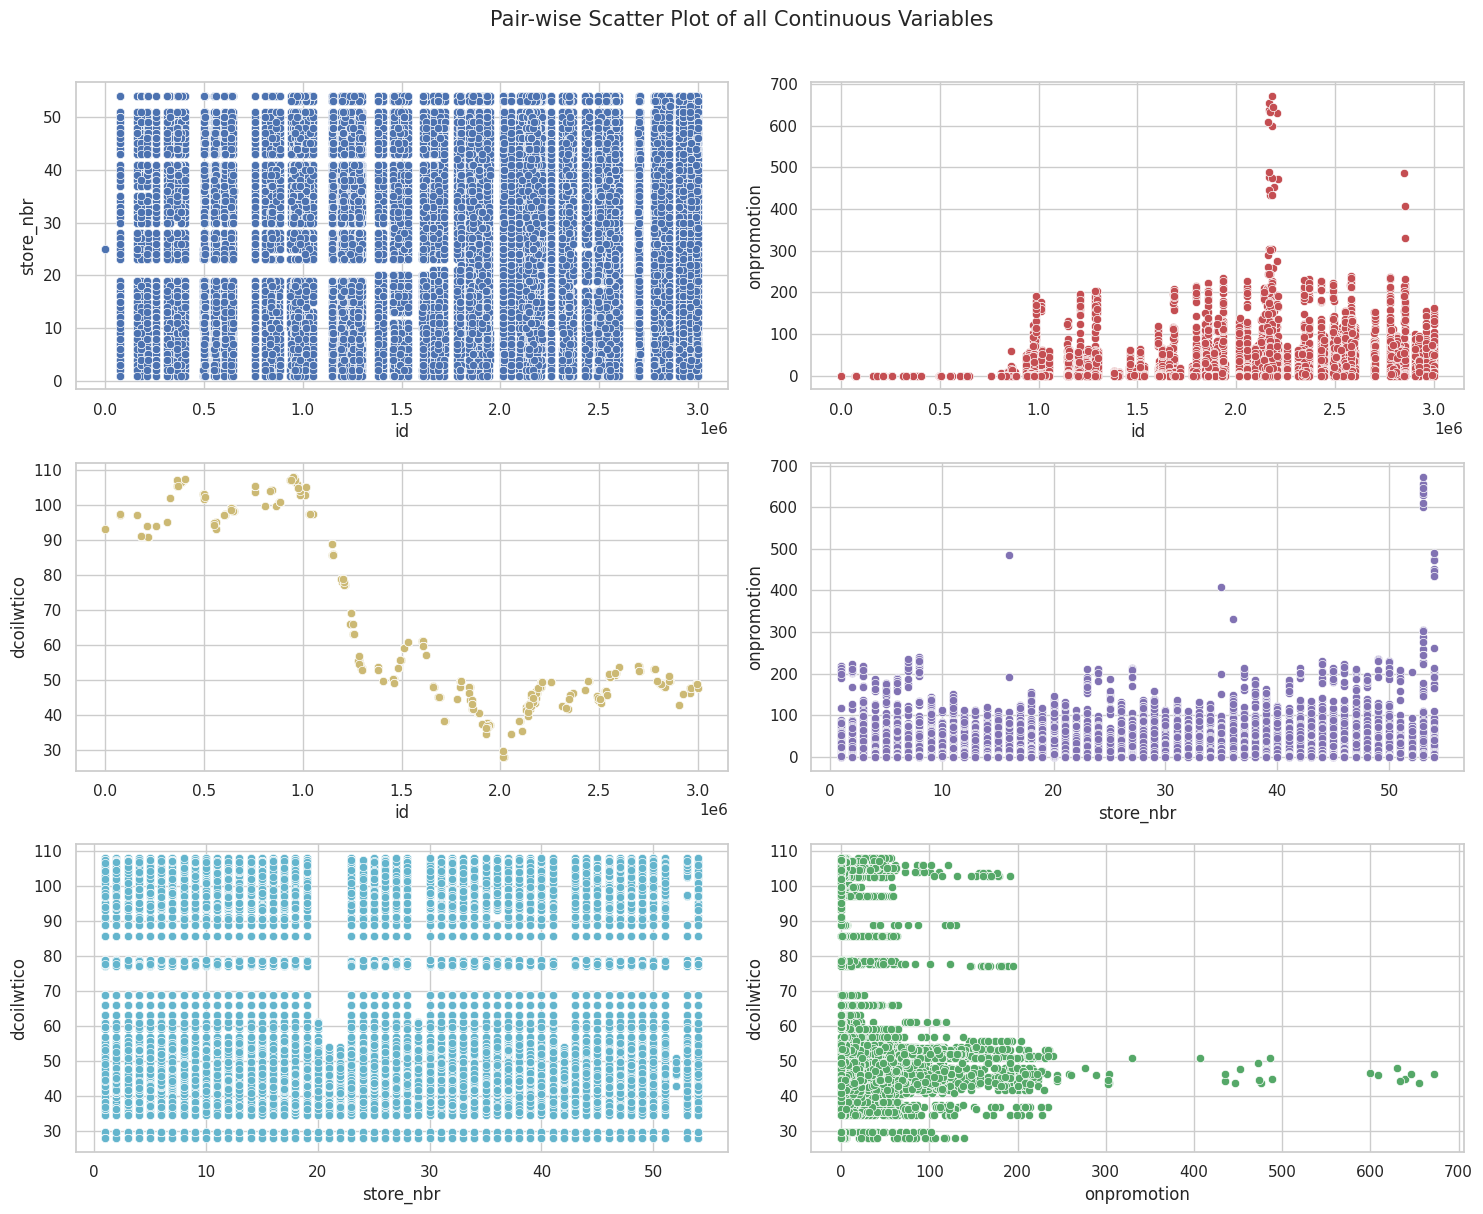

Could not draw some Distribution Plots


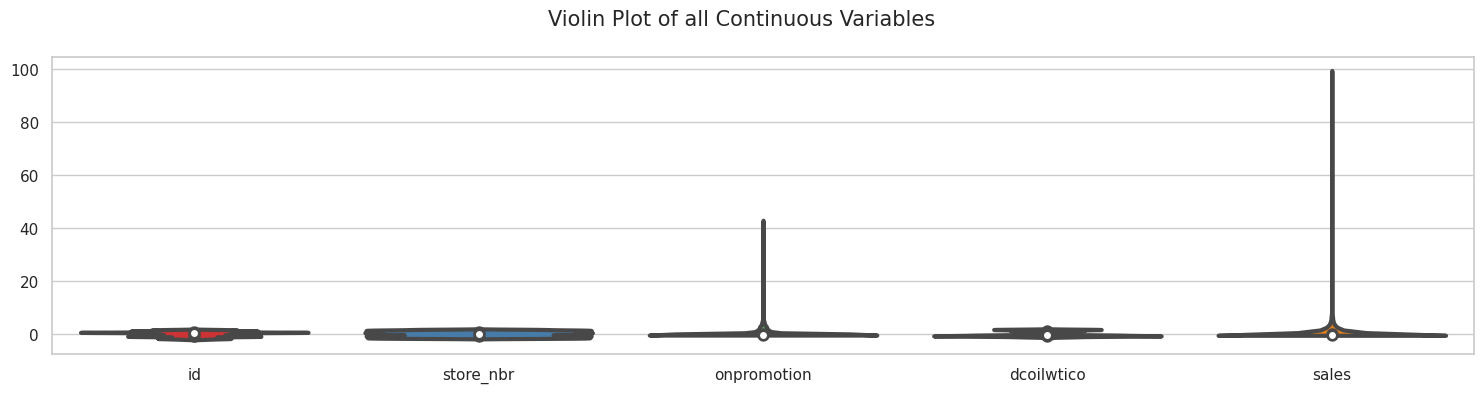

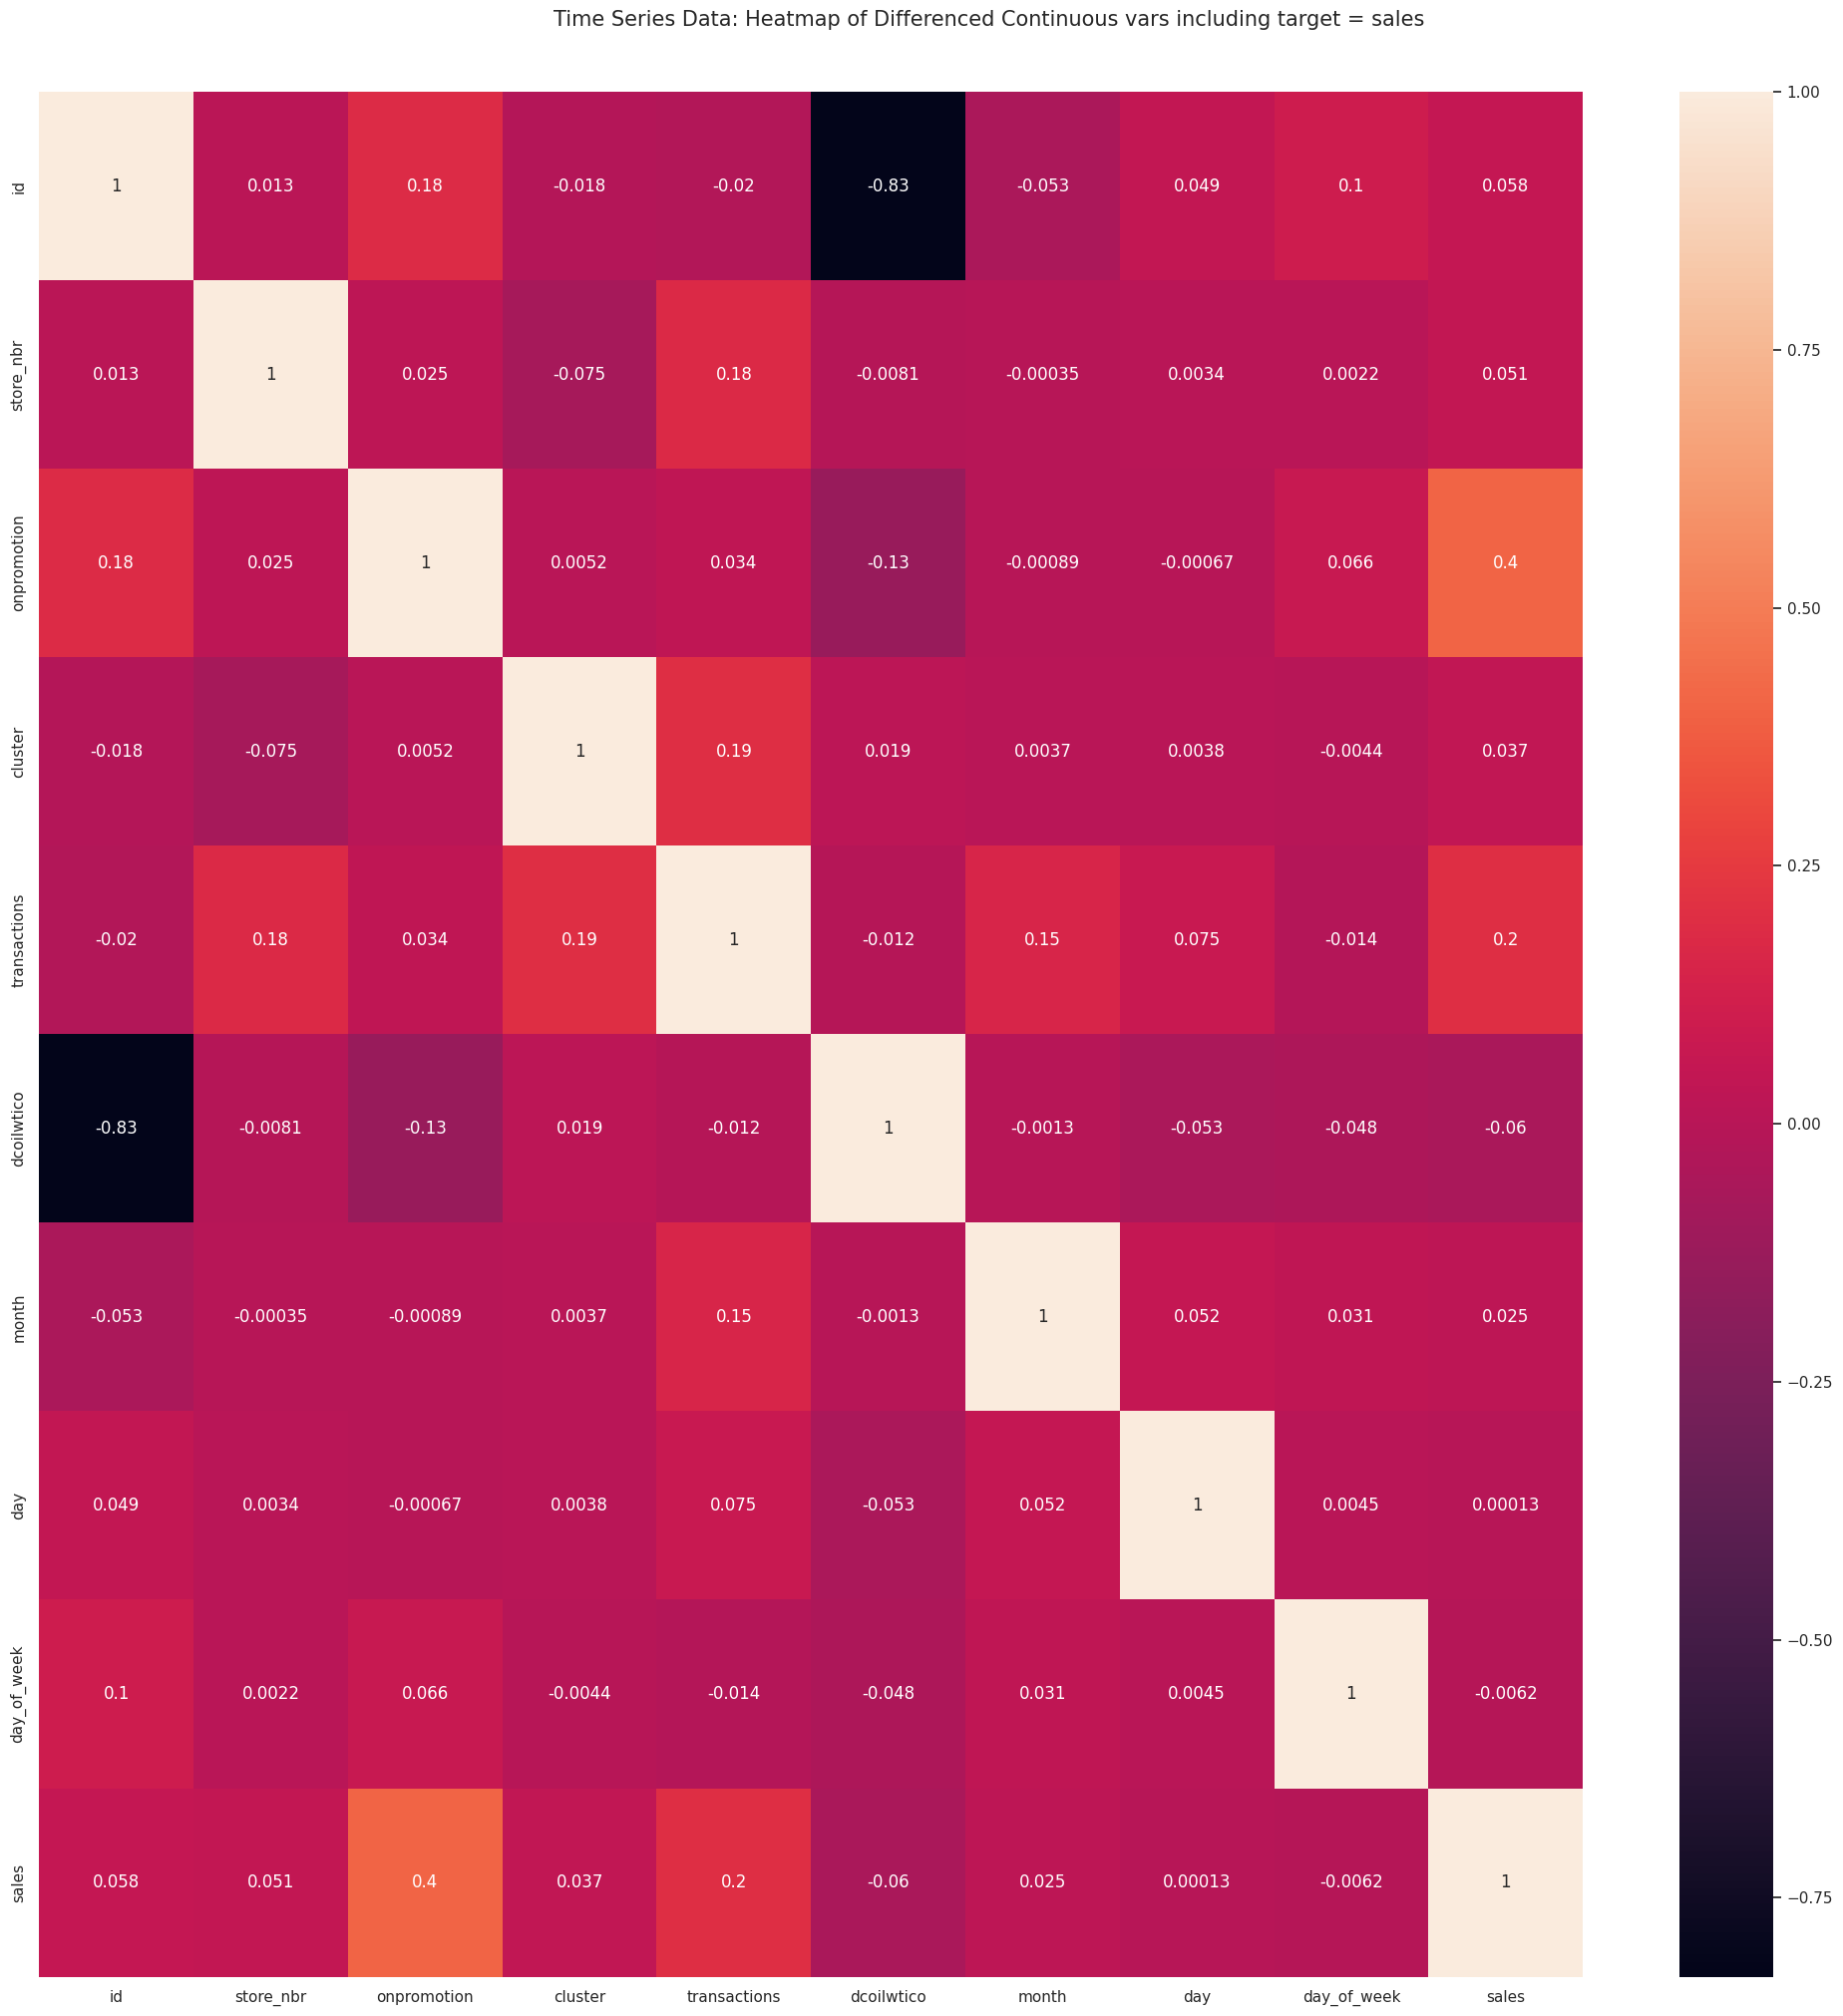

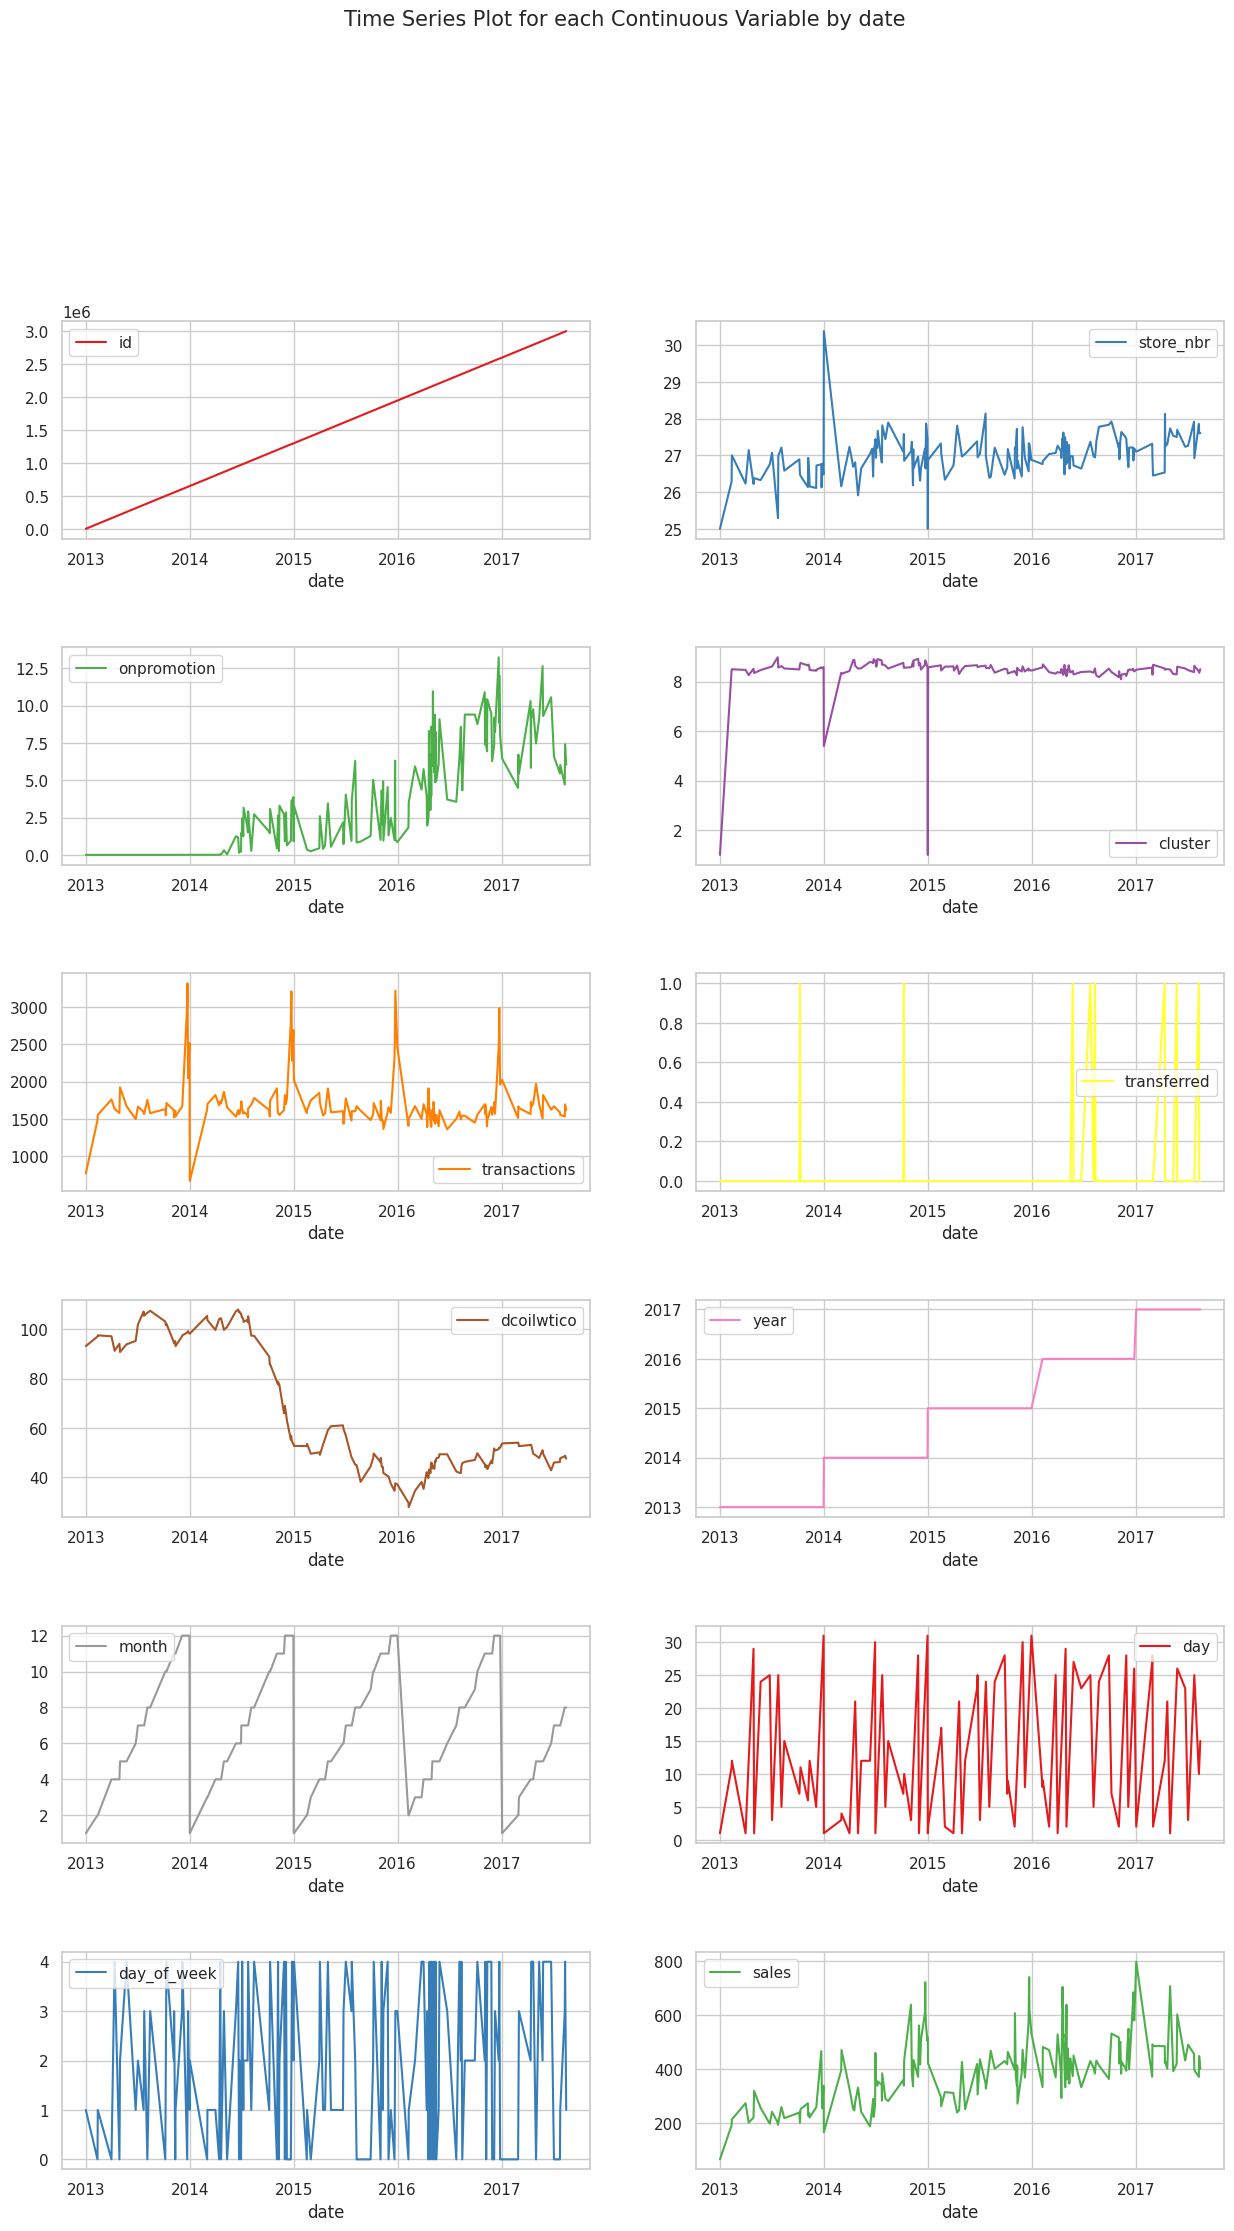

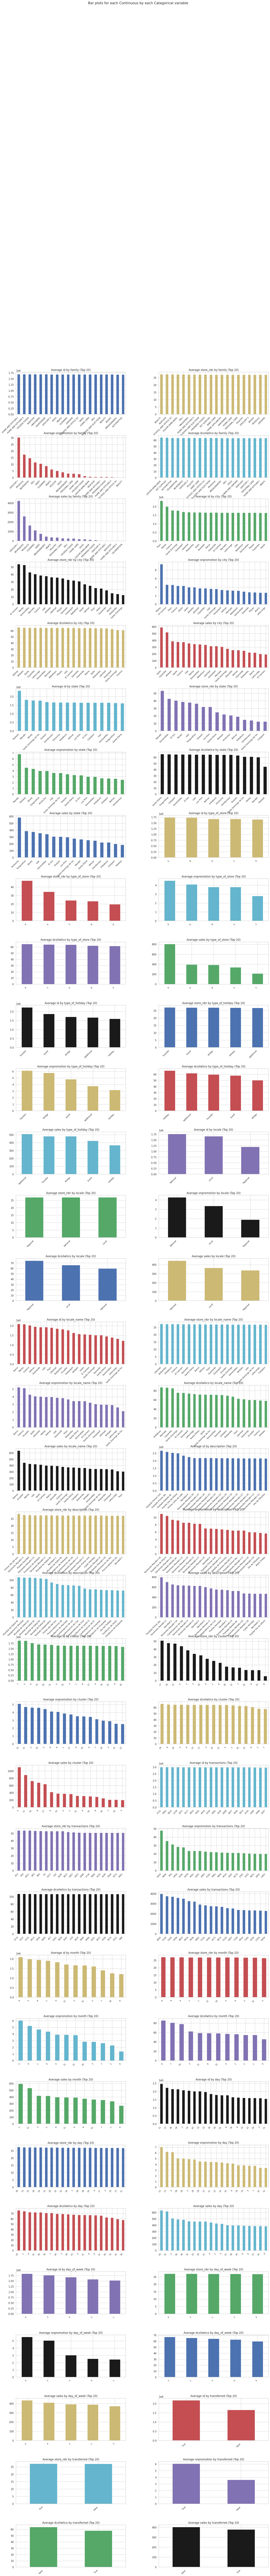

All Plots done
Time to run AutoViz = 55 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


In [16]:
from autoviz import AutoViz_Class
%matplotlib inline

AV = AutoViz_Class()

df = pd.DataFrame(final_dataset)

dft = AV.AutoViz(
    "",
    sep=",",
    depVar="sales",
    dfte=df,
    header=0,
    verbose=1,
    lowess=False,
    chart_format="svg",
    max_rows_analyzed=150000,
    max_cols_analyzed=30,
    save_plot_dir=None
)


In [17]:
design_report = ProfileReport(final_dataset)
design_report.to_file(output_file='report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
sweet_report = sv.analyze(final_dataset, "sales")
sweet_report.show_html('sweetviz_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Preprocessing

In [19]:
# Define a list of dataframes and their corresponding labels
datasets = [
    (final_dataset, "Final Dataframe"),
]

# Loop through each dataframe and label pair
for df, label in datasets:
    print("================================={}=================================".format(label))
    explore_dataframe(df)


=================================Final Dataframe=================================
-------------------------------TOP 5 RECORDS-----------------------------
+----+-------+---------------------+-------------+------------------+---------+---------------+--------+-----------+-----------------+-----------+----------------+-------------------+----------+---------------+---------------+---------------+--------------+--------+---------+-------+---------------+
|    |    id | date                |   store_nbr | family           |   sales |   onpromotion | city   | state     | type_of_store   |   cluster |   transactions | type_of_holiday   | locale   | locale_name   | description   | transferred   |   dcoilwtico |   year |   month |   day |   day_of_week |
|----+-------+---------------------+-------------+------------------+---------+---------------+--------+-----------+-----------------+-----------+----------------+-------------------+----------+---------------+---------------+---------------+

In [20]:
final_dataset.head(5)

,id,date,store_nbr,family,sales,onpromotion,city,state,type_of_store,cluster,transactions,type_of_holiday,locale,locale_name,description,transferred,dcoilwtico,year,month,day,day_of_week
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01,2013,2,11,0
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01,2013,2,11,0
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01,2013,2,11,0
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01,2013,2,11,0
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.01,2013,2,11,0


# Feature Engineering

### Dropping Unnecessary Columns in The Merged Dataset

In [21]:
columns_to_drop = ['date', 'id', 'locale', 'locale_name', 'description', 'type_of_store', 'transferred', 'state']
final_dataset = final_dataset.drop(columns=columns_to_drop)
final_dataset
final_dataset.to_csv('finalfeatures.csv')

In [22]:
# Define a list of dataframes and their corresponding labels
datasets = [
    (final_dataset, "Final Dataframe"),
]

# Loop through each dataframe and label pair
for df, label in datasets:
    print("================================={}=================================".format(label))
    explore_dataframe(df)


=================================Final Dataframe=================================
-------------------------------TOP 5 RECORDS-----------------------------
+----+-------------+------------------+---------+---------------+--------+-----------+----------------+-------------------+--------------+--------+---------+-------+---------------+
|    |   store_nbr | family           |   sales |   onpromotion | city   |   cluster |   transactions | type_of_holiday   |   dcoilwtico |   year |   month |   day |   day_of_week |
|----+-------------+------------------+---------+---------------+--------+-----------+----------------+-------------------+--------------+--------+---------+-------+---------------|
|  0 |           1 | AUTOMOTIVE       |       0 |             0 | Quito  |        13 |            396 | Holiday           |        97.01 |   2013 |       2 |    11 |             0 |
|  1 |           1 | MAGAZINES        |       0 |             0 | Quito  |        13 |            396 | Holiday     

In [23]:
# Assuming 'df' is your DataFrame and 'type_of_holiday' is the column containing the year values
unique_type_of_holiday = final_dataset['type_of_holiday'].unique()
print(unique_type_of_holiday)

# Assuming 'df' is your DataFrame and 'city' is the column containing the year values
unique_city = final_dataset['city'].unique()
print(unique_city)

# Assuming 'df' is your DataFrame and 'year' is the column containing the year values
unique_years = final_dataset['year'].unique()
print(unique_years)


['Holiday' 'Additional' 'Transfer' 'Event' 'Bridge']
['Quito' 'Machala' 'Esmeraldas' 'Playas' 'Cuenca' 'Guayaquil' 'Loja'
 'El Carmen' 'Ambato' 'Santo Domingo' 'Quevedo' 'Guaranda' 'Ibarra'
 'Cayambe' 'Latacunga' 'Riobamba' 'Babahoyo' 'Daule' 'Salinas' 'Libertad'
 'Manta' 'Puyo']
[2013 2014 2015 2016 2017]


### Storing the final features before modelling in Mongodb

In [24]:
# Create a dictionary where keys are collection names and values are DataFrames
dataframe_dict = {
    'final_dataset': final_dataset,
}

# Delete all records from the collection
delete_collection_data(database_name, collection_name, cluster_uri)

# Insert DataFrame records into the collection
insert_dataframe_to_collection(database_name, collection_name, cluster_uri, dataframe_dict)


### MinMax Scaling & One hot encoding

In [25]:

def apply_minmax_scaling(data, num_cols,scaler):
    data[num_cols] = scaler.fit_transform(data[num_cols])
    return data

def apply_one_hot_encoding(data, categorical_columns):
    encoder = OneHotEncoder()
    one_hot_encoded_data = encoder.fit_transform(data[categorical_columns])

    # Create column names for the one-hot encoded data
    column_names = encoder.get_feature_names_out(categorical_columns)

    # Convert the one-hot encoded data to a DataFrame
    one_hot_encoded_df = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)

    # Concatenate the original dataframe with the one-hot encoded data
    data_encoded = pd.concat([data, one_hot_encoded_df], axis=1)

    # Drop the original categorical columns
    data_encoded.drop(categorical_columns, axis=1, inplace=True)

    return data_encoded

def apply_label_encoding(data, categorical_columns):
    label_encoder = LabelEncoder()
    for col in categorical_columns:
        data[col] = label_encoder.fit_transform(data[col])
    return data

scaler = MinMaxScaler()

In [26]:
from sklearn.preprocessing import LabelEncoder
# Assuming 'final_dataset' is the input dataset
#num_cols = ['sales', 'transactions', 'dcoilwtico']
#final_dataset_scaled = apply_minmax_scaling(final_dataset, num_cols,scaler)

one_hot_encoding_columns = ["family"]
final_dataset_encoded = apply_one_hot_encoding(final_dataset, one_hot_encoding_columns)

label_encoding_columns = ["city", "type_of_holiday"]
final_dataset_encoded = apply_label_encoding(final_dataset_encoded, label_encoding_columns)

# Print the head of the encoded DataFrame
final_dataset_encoded.head()

,store_nbr,sales,onpromotion,city,cluster,transactions,type_of_holiday,dcoilwtico,year,month,day,day_of_week,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,family_FROZEN FOODS,family_GROCERY I,family_GROCERY II,family_HARDWARE,family_HOME AND KITCHEN I,family_HOME AND KITCHEN II,family_HOME APPLIANCES,family_HOME CARE,family_LADIESWEAR,family_LAWN AND GARDEN,family_LINGERIE,"family_LIQUOR,WINE,BEER",family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,1.0,0.0,0.0,18,13,396,3,97.01,2013,2,11,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,18,13,396,3,97.01,2013,2,11,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,21.0,0.0,18,13,396,3,97.01,2013,2,11,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,18,13,396,3,97.01,2013,2,11,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,3.0,0.0,18,13,396,3,97.01,2013,2,11,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train test split

In [27]:
train_set = final_dataset_encoded.loc[final_dataset_encoded['year'].isin([2013, 2014, 2015, 2016])]
eval_set = final_dataset_encoded.loc[final_dataset_encoded['year'] == 2017]
print(train_set.shape,eval_set.shape)

(284889, 45) (37158, 45)


In [28]:
# For the training set
X_train = train_set.drop('sales', axis=1)
y_train = train_set['sales']

# For the evaluation set
X_eval = eval_set.drop('sales', axis=1)
y_eval = eval_set['sales']

### Modelling & Evaluation Metrics

In [33]:
def calculate_metrics(y_eval, predictions):
    mse = mean_squared_error(y_eval, predictions)
    mae = mean_absolute_error(y_eval, predictions)

    y_eval_abs = abs(y_eval)
    predictions_abs = abs(predictions)

    rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, predictions_abs))

    r_squared = 1 - (mse / np.var(y_eval))

    return mse, mae, rmsle, r_squared

def create_results_dataframe(model_name, mse, mae, rmsle, r_squared):
    results_df = pd.DataFrame({
        'Model': [model_name],
        'RMSLE': [rmsle],
        'RMSE': [np.sqrt(mse)],
        'MSE': [mse],
        'MAE': [mae],
        'R²': [r_squared]
    }).round(2)
    return results_df


def linear_regression_model(X_train, y_train, X_eval, y_eval):
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_predictions = lr_model.predict(X_eval)

    mse, mae, rmsle,r_squared = calculate_metrics(y_eval, lr_predictions)

    results_lr = create_results_dataframe('Linear Regression', mse, mae, rmsle,r_squared)

    return results_lr

def random_forest_regression_model(X_train, y_train, X_eval, y_eval):
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_eval)

    mse, mae, rmsle,r_squared = calculate_metrics(y_eval, rf_predictions)

    results_rf = create_results_dataframe('Random Forest Regression', mse, mae, rmsle,r_squared)

    return results_rf


def xgboost_regression_model(X_train, y_train, X_eval, y_eval):
    # XGBoost Regression Model
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_eval)

    mse, mae, rmsle,r_squared = calculate_metrics(y_eval, xgb_predictions)

    results_xg = create_results_dataframe('XGBoost Regression', mse, mae, rmsle,r_squared)

    return results_xg

In [30]:
# Linear Regression
results_lr = linear_regression_model(X_train, y_train, X_eval, y_eval)
print("Results for Linear Regression:")
print(results_lr)

Results for Linear Regression:
        Model         RMSLE   RMSE      MSE      MAE    R² 
0  Linear Regression  2.45   815.86  665626.69  313.0  0.64


In [31]:

# Random Forest Regression
results_rf = random_forest_regression_model(X_train, y_train, X_eval, y_eval)
print("Results for Random Forest Regression:")
print(results_rf)


Results for Random Forest Regression:
            Model            RMSLE   RMSE      MSE       MAE    R² 
0  Random Forest Regression  0.55   588.76  346637.06  109.94  0.81


In [34]:
# XGBoost Model
results_xg = xgboost_regression_model(X_train, y_train, X_eval, y_eval)
print("Results for XGBoost Regression:")
print(results_xg)

Results for XGBoost Regression:
         Model         RMSLE   RMSE      MSE       MAE   R² 
0  XGBoost Regression  1.36   606.77  368168.67  133.34  0.8


In [35]:

def process_results(results_lr, results_rf, results_xgb):
    # Initialize the results dataframe
    results_df = pd.DataFrame(columns=['Model', 'RMSLE', 'RMSE', 'MSE', 'MAE','R²'])

    # Append all results to the results dataframe
    results_df = results_df.append(results_lr)
    results_df = results_df.append(results_rf)
    results_df = results_df.append(results_xgb)

    # Sort the results_df based on RMSLE in ascending order
    results_df = results_df.sort_values(by='RMSLE', ascending=True)

    # Reset the index of the DataFrame
    results_df = results_df.reset_index(drop=True)

    return results_df

# Call the function with the results
final_results = process_results(results_lr, results_rf, results_xg)

final_results

,Model,RMSLE,RMSE,MSE,MAE,R²
0,Random Forest Regression,0.55,588.76,346637.06,109.94,0.81
1,XGBoost Regression,1.36,606.77,368168.67,133.34,0.80
2,Linear Regression,2.45,815.86,665626.69,313.00,0.64


## Hyperparameter Tuning

In [55]:
import pickle

def save_model(model, filename):
    """
    Save the given model using pickle.

    Parameters:
    - model: The trained model to be saved.
    - filename: The filename (including path) to save the model to.
    """
    with open(filename, 'wb') as file:
        pickle.dump(model, file)


def tune_random_forest(X_train, y_train, X_eval, y_eval):
    # Define the parameter grid for tuning the random forest model
    param_grid = {
        'n_estimators': [100],
        'max_depth': [5],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
        'max_features': ['sqrt']
    }

    # Create Random Forest model
    rf_model = RandomForestRegressor(random_state=42)

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(rf_model, param_distributions=param_grid,
                                       n_iter=10, scoring='neg_mean_squared_error', cv=5,
                                       n_jobs=-1, random_state=42)

    # Fit RandomizedSearchCV to the data
    random_search.fit(X_train, y_train)

    # Get the best model and its hyperparameters
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_

    # Make predictions using the best model
    predictions = best_model.predict(X_eval)

    # Calculate metrics for the best model
    mse = mean_squared_error(y_eval, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_eval, predictions)

    # Apply absolute value to both predicted and target values
    abs_predictions = np.abs(predictions)
    abs_y_eval = np.abs(y_eval)

    # Calculate RMSLE using the absolute values
    rmsle = np.sqrt(mean_squared_log_error(abs_y_eval, abs_predictions))

    r_squared = 1 - (mse / np.var(y_eval))

    # Create a DataFrame to store results for the best Random Forest model
    results_df = pd.DataFrame({'Model': ['Best Random Forest'],
                               'RMSLE': [rmsle],
                               'RMSE': [rmse],
                               'MSE': [mse],
                               'MAE': [mae],
                               'R²': [r_squared]}).round(2)

    # Print the results DataFrame
    print(results_df)

    # Save the results DataFrame as a pickle file
    save_model(rf_model, 'model.pkl')


In [56]:
tune_random_forest(X_train,y_train,X_eval,y_eval)

         Model         RMSLE   RMSE      MSE       MAE    R² 
0  Best Random Forest   2.9   877.84  770594.52  377.65  0.58


# Inference

In [38]:
holidays_events1 = pd.read_csv('/content/drive/MyDrive/AIGot/Time Series Forecasting/holidays_events.csv')
oil1 = pd.read_csv('/content/drive/MyDrive/AIGot/Time Series Forecasting/oil.csv')
stores1 = pd.read_csv('/content/drive/MyDrive/AIGot/Time Series Forecasting/stores.csv')
transactions1 = pd.read_csv('/content/drive/MyDrive/AIGot/Time Series Forecasting/transactions.csv')
train1=pd.read_csv('/content/drive/MyDrive/AIGot/Time Series Forecasting/train.csv')
test1=pd.read_csv('/content/drive/MyDrive/AIGot/Time Series Forecasting/test.csv')


# print out the shapes of the dataset (train & test)
print("holidays_events",holidays_events.shape)
print("oil dataset",oil.shape)
print("stores dataset",stores.shape)
print("transactions dataset",transactions.shape)
print("Train dataset",train.shape)
print("Test dataset",test.shape)

def merge_datasets(test, stores, transactions, holidays_events, oil):
    merged_dataset1 = test.merge(stores, on='store_nbr', how="left")
    merged_dataset2 = merged_dataset1.merge(transactions, on=['date', 'store_nbr'], how="left")
    merged_dataset3 = merged_dataset2.merge(holidays_events, on='date', how="left")
    merged_dataset = merged_dataset3.merge(oil, on='date', how="left")

    # Rename the columns
    merged_dataset = merged_dataset.rename(columns={'type_x': 'type_of_store', 'type_y': 'type_of_holiday'})

    return merged_dataset

#'train', 'stores', 'transactions', 'holidays_events', and 'oil' are the input datasets
submission = merge_datasets(test1, stores1, transactions1, holidays_events1, oil1)
submission.head(5)

holidays_events (350, 6)
oil dataset (1218, 2)
stores dataset (54, 5)
transactions dataset (83488, 3)
Train dataset (3000892, 6)
Test dataset (28512, 5)


,id,date,store_nbr,family,onpromotion,city,state,type_of_store,cluster,transactions,type_of_holiday,locale,locale_name,description,transferred,dcoilwtico
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN,NaN,46.8
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN,NaN,46.8
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN,NaN,46.8
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN,NaN,46.8
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN,NaN,46.8


In [39]:
import pandas as pd

def extract_date_components(df, date_column):
    """
    Extracts year, month, and day components from a date column in a DataFrame.

    Args:
    df (pd.DataFrame): DataFrame containing the date column.
    date_column (str): Name of the date column in the DataFrame.

    Returns:
    pd.DataFrame: DataFrame with year, month, and day components added as new columns.
    """
    # Convert the date column to datetime
    df[date_column] = pd.to_datetime(df[date_column])

    # Extract year, month, and day components
    df['year'] = df[date_column].dt.year
    df['month'] = df[date_column].dt.month
    df['day'] = df[date_column].dt.day
    df['day_of_week'] = df[date_column].dt.dayofweek

    return df


In [40]:
# convert to datetime
convert_to_datetime([submission])

# date
submission_encoded = extract_date_components(submission, 'date')
submission_encoded.head(5)

,id,date,store_nbr,family,onpromotion,city,state,type_of_store,cluster,transactions,type_of_holiday,locale,locale_name,description,transferred,dcoilwtico,year,month,day,day_of_week
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN,NaN,46.8,2017,8,16,2
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN,NaN,46.8,2017,8,16,2
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN,NaN,46.8,2017,8,16,2
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN,NaN,46.8,2017,8,16,2
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN,NaN,46.8,2017,8,16,2


In [41]:

#drop the columns
columns_to_drop = ['date', 'id', 'locale', 'locale_name', 'description', 'type_of_store', 'transferred', 'state']
submission_encoded_dataset = submission_encoded.drop(columns=columns_to_drop)
submission_encoded_dataset

,store_nbr,family,onpromotion,city,cluster,transactions,type_of_holiday,dcoilwtico,year,month,day,day_of_week
0,1,AUTOMOTIVE,0,Quito,13,NaN,NaN,46.80,2017,8,16,2
1,1,BABY CARE,0,Quito,13,NaN,NaN,46.80,2017,8,16,2
2,1,BEAUTY,2,Quito,13,NaN,NaN,46.80,2017,8,16,2
3,1,BEVERAGES,20,Quito,13,NaN,NaN,46.80,2017,8,16,2
4,1,BOOKS,0,Quito,13,NaN,NaN,46.80,2017,8,16,2
...,...,...,...,...,...,...,...,...,...,...,...,...
28507,9,POULTRY,1,Quito,6,NaN,NaN,47.26,2017,8,31,3
28508,9,PREPARED FOODS,0,Quito,6,NaN,NaN,47.26,2017,8,31,3
28509,9,PRODUCE,1,Quito,6,NaN,NaN,47.26,2017,8,31,3
28510,9,SCHOOL AND OFFICE SUPPLIES,9,Quito,6,NaN,NaN,47.26,2017,8,31,3


In [42]:
# Assuming 'dataframe' is your pandas DataFrame and 'column_name' is the name of the column
unique_values = submission_encoded_dataset['transactions'].unique()
print(unique_values)


[nan]


In [43]:
'''
def fill_missing_values(dataframe, columns):
    for column in columns:
        # Forward fill missing values from the first row to the last non-missing row
        dataframe[column] = dataframe[column].fillna(method='ffill')

        # Backward fill missing values from the last row to the first non-missing row
        dataframe[column] = dataframe[column].fillna(method='bfill')

    return dataframe

# Example usage:
# Assuming 'oil' is the DataFrame and 'columns' is a list of column names with missing values
columns_to_fill = ['transactions']  # Specify the column names to fill missing values
oil_filled = fill_missing_values(submission_encoded_dataset, columns_to_fill)
'''

"\ndef fill_missing_values(dataframe, columns):\n    for column in columns:\n        # Forward fill missing values from the first row to the last non-missing row\n        dataframe[column] = dataframe[column].fillna(method='ffill')\n\n        # Backward fill missing values from the last row to the first non-missing row\n        dataframe[column] = dataframe[column].fillna(method='bfill')\n\n    return dataframe\n\n# Example usage:\n# Assuming 'oil' is the DataFrame and 'columns' is a list of column names with missing values\ncolumns_to_fill = ['transactions']  # Specify the column names to fill missing values\noil_filled = fill_missing_values(submission_encoded_dataset, columns_to_fill)\n"

In [44]:
# Assuming 'final_dataset' is the input dataset
#num_cols = ['transactions', 'dcoilwtico']
#submission_scaled = apply_minmax_scaling(submission_encoded_dataset, num_cols,scaler)

one_hot_encoding_columns = ["family"]
submission_one_encoded = apply_one_hot_encoding(submission_encoded_dataset, one_hot_encoding_columns)

label_encoding_columns = ["city", "type_of_holiday"]
submission_one_hot_encoded = apply_label_encoding(submission_one_encoded, label_encoding_columns)

# Print the head of the encoded DataFrame
submission_one_hot_encoded.head()

,store_nbr,onpromotion,city,cluster,transactions,type_of_holiday,dcoilwtico,year,month,day,day_of_week,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,family_FROZEN FOODS,family_GROCERY I,family_GROCERY II,family_HARDWARE,family_HOME AND KITCHEN I,family_HOME AND KITCHEN II,family_HOME APPLIANCES,family_HOME CARE,family_LADIESWEAR,family_LAWN AND GARDEN,family_LINGERIE,"family_LIQUOR,WINE,BEER",family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,1,0,18,13,NaN,1,46.8,2017,8,16,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,18,13,NaN,1,46.8,2017,8,16,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2,18,13,NaN,1,46.8,2017,8,16,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,20,18,13,NaN,1,46.8,2017,8,16,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,18,13,NaN,1,46.8,2017,8,16,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
import pandas as pd

# Assuming df is your DataFrame
default_value = 0  # or any other default value
submission_one_hot_encoded['transactions'].fillna(default_value, inplace=True)
submission_one_hot_encoded['dcoilwtico'].fillna(default_value, inplace=True)


In [59]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

lr_predictions = rf_model.predict(submission_one_hot_encoded)
lr_predictions

# Combine 'id' from submission DataFrame and 'predictions' from lr_predictions DataFrame
sample_submission = pd.DataFrame({'id': submission['id'], 'sales': lr_predictions})

# Save combined DataFrame to a CSV file
sample_submission.to_csv('sample_submission.csv', index=False)

sample_submission.head(100)

,id,sales
0,3000888,1.790000
1,3000889,0.250000
2,3000890,14.142920
3,3000891,700.420000
4,3000892,0.060000
5,3000893,138.766700
6,3000894,7.260000
7,3000895,159.510000
8,3000896,238.770000
9,3000897,80.382090
